In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
# Load the dataset
dataset = pd.read_csv('creditcard.csv')

In [7]:
# Separate features and target labels
X = dataset.drop('Class', axis=1)
y = dataset['Class']

In [8]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:

# Split data into training and test sets, using only normal transactions (Class = 0) for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
# Use only normal transactions (Class = 0) for training
X_train_normal = X_train[y_train == 0]
X_test_normal = X_test[y_test == 0]
X_test_anomalies = X_test[y_test == 1]

In [11]:
# Define input dimensions
input_dim = X_train_normal.shape[1]

In [12]:
encoder=models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32,activation="relu"),
    layers.Dense(16,activation="relu"),
    layers.Dense(8,activation="relu")
])

In [13]:
decoder=models.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(16,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(input_dim,activation="linear")
])

In [14]:
# Build autoencoder
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss="mean_squared_error", optimizer="adam")

In [15]:
# Train the autoencoder on normal transactions only
autoencoder.fit(X_train_normal, X_train_normal, epochs=10, shuffle=True, batch_size=64)


Epoch 1/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.6929
Epoch 2/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4287
Epoch 3/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3844
Epoch 4/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3600
Epoch 5/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.3359
Epoch 6/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3303
Epoch 7/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3134
Epoch 8/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.2980
Epoch 9/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2894
Epoch 10/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2754


In [16]:
# Predict and calculate MSE on the test set
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [17]:
# Set a threshold based on the 95th percentile of reconstruction errors on the normal test data
threshold = np.percentile(mse[y_test == 0], 95)
print("Reconstruction error threshold:", threshold)

Reconstruction error threshold: 0.783886136881047


In [18]:
# Identify anomalies based on the threshold
anomalies = mse > threshold
total_anomalies = np.sum(anomalies)
print("Total No. of Anomalies Detected:", total_anomalies)

Total No. of Anomalies Detected: 2928


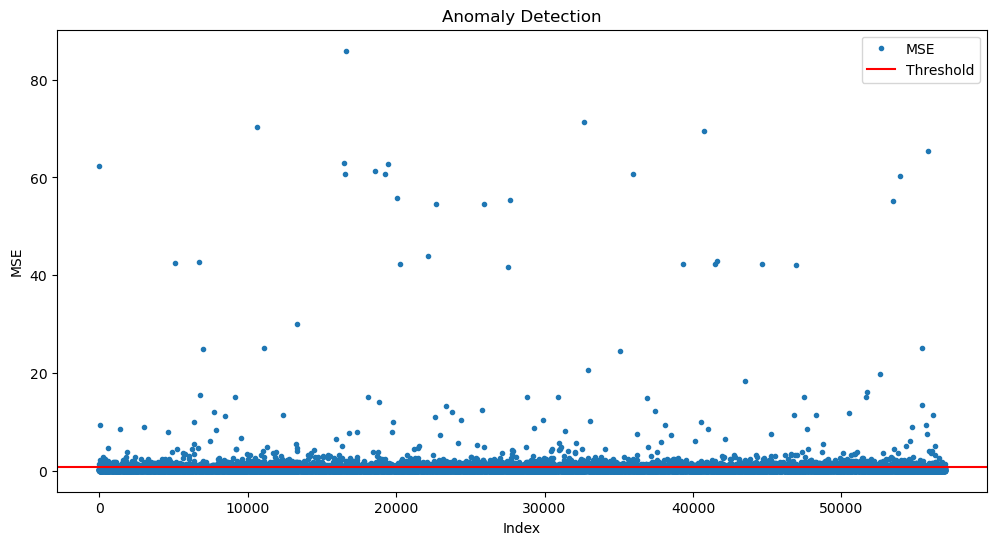

In [19]:
# Plot the MSE and threshold for visualization
plt.figure(figsize=(12,6))
plt.plot(mse, label="MSE", marker='o', linestyle='', markersize=3)
plt.axhline(threshold, label="Threshold", color="red")
plt.xlabel("Index")
plt.ylabel("MSE")
plt.title("Anomaly Detection")
plt.legend()
plt.show()

In [20]:
# Evaluate with confusion matrix and classification report
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, anomalies)
print(conf_matrix)

Confusion Matrix:
[[54020  2844]
 [   14    84]]


In [21]:
print("Classification Report:")
class_report = classification_report(y_test, anomalies)
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.86      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.51     56962
weighted avg       1.00      0.95      0.97     56962



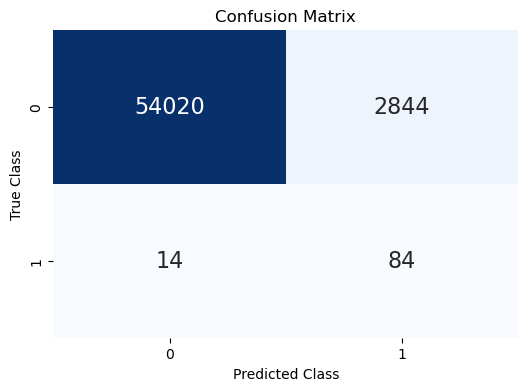

In [22]:
# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, anomalies)
precision = precision_score(y_test, anomalies)
recall = recall_score(y_test, anomalies)

In [24]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9498
Precision: 0.0287
Recall: 0.8571
